In [1]:
from konlpy.tag import Mecab
from tqdm import tqdm
import re
import pickle
import csv
import pandas as pd
from pandas import DataFrame 
import numpy as np
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import time

C:\Users\mjsk1\anaconda3\envs\Pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('k_stopwords.txt', 'r',encoding='utf-8') as file:
    lines = file.readlines()
stop = [line.strip() for line in lines]

In [3]:
df1 = pd.read_excel("C:/Users/mjsk1/Desktop/미팅 발표/3 data/elect1.xlsx")
df2 = pd.read_excel("C:/Users/mjsk1/Desktop/미팅 발표/3 data/elect2.xlsx")
data_el=pd.concat([df1, df2,], ignore_index=True)

In [4]:
excel_file_path = 'C:/Users/mjsk1/Desktop/미팅 발표/3 data/data_election.xlsx'  # 저장할 Excel 파일 경로
data_el.to_excel(excel_file_path, index=False) 

In [5]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ",}
def clean(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()


import re

In [6]:
def clean_str(text):
    pattern = '([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)' # E-mail제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+' # URL제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '<[^>]*>'         # HTML 태그 제거
    text = re.sub(pattern=pattern, repl='', string=text)
    pattern = '[^\w\s\n]'         # 특수기호제거
    text = re.sub(pattern=pattern, repl='', string=text)
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', string=text)
    text = re.sub('\n', '.', string=text)
    return text 

In [7]:
title=[]
text=[]
for i in range(len(data_el)):
    title.append(clean_str(data_el.loc[i]['Title']))
    text.append(clean_str(data_el.loc[i]['text']))

In [8]:
corpus = [f'{elem1} {elem2}' for elem1, elem2 in zip(title, text)]
df = pd.DataFrame(corpus)
corpus=df.rename(columns={0:'text'})

In [9]:
excel_file_path = 'C:/Users/mjsk1/Desktop/미팅 발표/3 data/data_election.xlsx'  # 저장할 Excel 파일 경로
corpus.to_excel(excel_file_path, index=False) 

In [10]:
import konlpy
import re

def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if  pos == 'Noun':
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words


tokenized_list = []

for text in corpus['text']:
    tokenized_list.append(tokenize_korean_text(text))

print(len(tokenized_list))
print(tokenized_list[1])

2038
['그린벨트', '해제', '역대', '최대', '규모', '군사시설', '보호', '구역', '해제', '공약', '난발', '총선', '대비', '부동산', '투자', '계명', '전화', '부동산', '불경기', '지속', '가운데', '선용', '선심', '선거', '공약', '난발', '부동산', '마니아', '주의', '땅', '투자', '수도권', '경기도', '지금', '자신', '입맛', '부동산', '철학', '때', '자연', '녹지', '지역', '그린벨트', '군사시설', '보호', '구역', '총선', '대비', '부동산', '투자', '계명', '토지', '및', '주택', '시장', '대신', '힐링', '시장', '투자', '과감', '도전', '투자', '개투', '아파트', '시장', '펜션', '시장', '돌변', '수도권', '땅', '관심', '도', '접근성', '수도권', '펜션', '단지', '집중', '지경', '접근성', '예', '대부도', '강화도', '남이섬', '일대', '가평군', '춘천시', '언론', '주의', '테', '총선', '공약', '관련', '기사', '주의', '과대', '포장', '기획', '기사', '현혹', '정치인', '공약', '이행', '률', '주거', '문화', '변화', '문화', '변화', '계', '내', '집', '마련', '포기', '증가', '관광인', '구도', '급증', '세', '주거', '문화', '놀이', '문화', '더', '강세', '충청도', '당진시', '실패', '확률', '팍', '예', '탕', '주의', '탕', '주의자', '실패', '확률', '실패', '현상', '건', '업자', '투자자', '모두', '탕', '주의자', '일', '때', '탕', '투자', '여유', '투자', '서울', '강남', '용인시', '규제', '신경', '효과', '늘', '때문', '단발', '속성', '예', '분양', '제', '토지',

In [20]:
tokenized_list2 = [[item for item in sublist if item not in ["대한","대한민국","한국","있습니다","잘","우리","했다","해서","있다","한다","생","됩니다","번","때","이러한","입니다","합니다"]] for sublist in tokenized_list]
tokenized_list2 = [[item for item in sublist if item not in stop] for sublist in tokenized_list2]
tokenized_list2 = [[word for word in sublist if len(word) > 1] for sublist in tokenized_list2]

In [55]:
from collections import Counter
def get_word_frequency_from_nested_list(nested_list):
    # 이중 리스트를 하나의 리스트로 펼치기
    words = [word for sublist in nested_list for word in sublist]
    
    # 펼친 리스트에서 단어 빈도수 계산
    word_freq = Counter(words)
    return word_freq
word_freq = get_word_frequency_from_nested_list(tokenized_list2)

In [56]:
len(word_freq)

25886

In [58]:
top_word_freq = word_freq.most_common(1000)
top_word_freq 

[('후보', 7213),
 ('총선', 6766),
 ('국민', 5687),
 ('민주당', 4815),
 ('선거', 3495),
 ('의원', 3176),
 ('지역', 3066),
 ('국회의원', 2361),
 ('공천', 2330),
 ('대표', 2306),
 ('정치', 2094),
 ('예비', 2054),
 ('대통령', 1888),
 ('이재명', 1816),
 ('여론조사', 1761),
 ('조사', 1731),
 ('위해', 1717),
 ('투표', 1655),
 ('윤석열', 1527),
 ('정부', 1439),
 ('정당', 1406),
 ('위원장', 1364),
 ('출마', 1333),
 ('사람', 1329),
 ('결과', 1302),
 ('지난', 1218),
 ('지역구', 1215),
 ('시민', 1199),
 ('서울', 1186),
 ('경선', 1175),
 ('공약', 1157),
 ('정책', 1132),
 ('국회', 1127),
 ('미래', 1123),
 ('위원회', 1115),
 ('대해', 1057),
 ('승리', 1035),
 ('발표', 1033),
 ('국가', 1025),
 ('세종', 1014),
 ('개혁', 1011),
 ('대전', 1007),
 ('통해', 956),
 ('정권', 935),
 ('뉴스', 933),
 ('때문', 929),
 ('경제', 927),
 ('선거구', 908),
 ('문제', 907),
 ('중앙', 906),
 ('발전', 894),
 ('관련', 871),
 ('생각', 856),
 ('지지', 850),
 ('민주', 847),
 ('지금', 845),
 ('조국', 835),
 ('추진', 817),
 ('지원', 806),
 ('부산', 803),
 ('한동훈', 795),
 ('심판', 792),
 ('사회', 790),
 ('지지율', 783),
 ('신당', 778),
 ('기관', 776),
 ('평가', 767),
 ('사업'

In [21]:
import json
with open('tokenlist2_data_el.json', 'w') as f:
    json.dump(tokenized_list2, f)

In [22]:
# bigram 생성에 필요한 library
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# vectorize & lda에 필요한 library
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [23]:
# Build the bigram models
bigram = Phrases(tokenized_list2, min_count=4, threshold=10)
bigram_mod = Phraser(bigram)
 
# See example
print(bigram_mod[tokenized_list2[0]])

['미국', '총선', '중국', '북한', '개입', '차단', '미국', '해상', '전력', '절반', '가까이', '총선', '한반도', '일대', '항모', '대의', '전력', '해도', '북한', '완전', '초토화', '대가', '중국', '중국', '북한', '지적', '무력', '도발', '총선', '개입', '사전', '차단', '의지', '행동', '정말', '김정은', '김일성_김정일', '달라', '애걸', '이재명', '위해', '지적', '도발', '지금', '북한', '야당', '민주당', '이재명', '전체주의', '공산당', '마찬가지', '내부', '혼란', '평양', '제외', '지역', '배급', '전혀', '이행', '공산_전체주의', '체제', '일보', '전입', '개발', '미사일', '하나로', '인민', '통제', '탈북자', '유투브', '방송', '북한', '개발', '엘리트', '청년', '과학자', '대거', '탈북', '남한', '내용', '김정은', '판사', '어차피', '각하', '전쟁', '북한', '완전', '흔적', '북한', '주민', '김정은', '미사일', '방이', '순간', '평양', '체제', '김정은', '행동', '대비', '차원', '미국', '이승만_대통령', '관철', '한미_상호', '방위_조약', '덕분']


In [24]:
words_bigram = [bigram_mod[doc] for doc in tokenized_list2]

In [25]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [26]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# vectorize & lda에 필요한 library
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [27]:
dictionary = corpora.Dictionary(words_bigram)  # 각 단어에 번호를 할당해줌
    # bigram 포함하는 과정을 생략하고 싶으면, 그냥 바로 여기에 tokenized_list를 넣어주면 됨

dictionary.filter_extremes(no_below=2, no_above=0.3)   
    # 2개의 문서 미만으로 등장하는 단어는 제외, 전체의 5% 이상으로 자주 등장하는 단어는 제외

corpus = [dictionary.doc2bow(text) for text in words_bigram]
print(corpus[0]) # 첫번째 corpus를 테스트로 출력: 몇 번째 단어가 몇 번 나왔는지 저장되어 있음

[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 4), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 3), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 7), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 3), (54, 1), (55, 2), (56, 2), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1)]


In [31]:
import gensim
a=0.2
b=0.2
num_topics = 4
passes = 5
iterations = 400
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary,
                                            iterations=iterations,passes=passes,
                                           alpha=a,eta=b,random_state=10)

In [32]:
ldamodel.print_topics(num_words=7) 

[(0,
  '0.008*"조국_혁신" + 0.007*"대통령" + 0.006*"투표" + 0.005*"영향" + 0.005*"전북" + 0.005*"시장" + 0.005*"전망"'),
 (1,
  '0.007*"대표" + 0.006*"진지" + 0.005*"고양시" + 0.005*"국회" + 0.005*"문제" + 0.005*"이재명" + 0.005*"지금"'),
 (2,
  '0.012*"교육" + 0.008*"의원" + 0.008*"예비_후보" + 0.007*"경선" + 0.007*"선정" + 0.007*"정신_교육" + 0.006*"내용"'),
 (3,
  '0.011*"목사" + 0.008*"기도" + 0.007*"회장" + 0.007*"교회" + 0.006*"제주" + 0.006*"대표_회장" + 0.005*"시민"')]

In [30]:
coherences=[]
perplexities=[]
passes=[]

for i in range(1,40,2):

    tic = time.time()
    
    lda = gensim.models.ldamodel.LdaModel(corpus, num_topics = 4, id2word=dictionary,
                                            iterations=400,passes=i,
                                           alpha=0.3,eta=0.3,random_state=10)
    print(i,"time:",time.time() - tic)

    cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', lda.log_perplexity(corpus),'\n\n')
    perplexities.append(lda.log_perplexity(corpus))

1 time: 6.131229877471924
Cpherence -3.896959528742848
Perplexity:  -9.345667459546508 


3 time: 9.759034156799316
Cpherence -3.9154270729596794
Perplexity:  -9.228706811503056 


5 time: 12.245861053466797
Cpherence -3.6445946457552827
Perplexity:  -9.152054127445668 


7 time: 13.914721727371216
Cpherence -3.770053997233982
Perplexity:  -9.111855700391096 


9 time: 15.496456861495972
Cpherence -3.7442625450777305
Perplexity:  -9.086870720331538 


11 time: 17.175532341003418
Cpherence -3.7427338987829057
Perplexity:  -9.069625803824376 


13 time: 18.784032344818115
Cpherence -3.747554857457577
Perplexity:  -9.057090213392998 


15 time: 20.328065872192383
Cpherence -3.766357535474586
Perplexity:  -9.047305002988175 


17 time: 21.914268255233765
Cpherence -3.7749584901400577
Perplexity:  -9.039353847103849 


19 time: 23.29530358314514
Cpherence -3.734996093603775
Perplexity:  -9.032710082054722 


21 time: 24.81844997406006
Cpherence -3.7451049747472327
Perplexity:  -9.0270473532

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 0, 'number of passes')

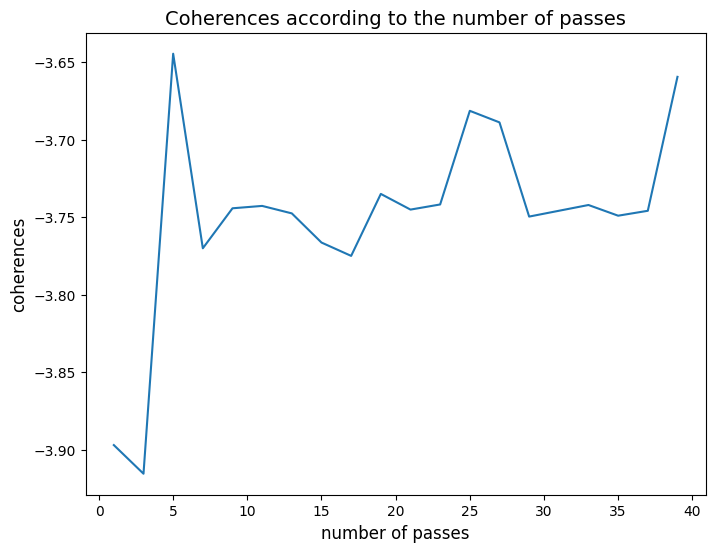

In [50]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
x=[i for i in range(1,40,2)]
ax1.plot(x,coherences)
ax1.set_title('Coherences according to the number of passes', size=14)
ax1.set_ylabel('coherences',fontsize=12)
ax1.set_xlabel('number of passes',fontsize=12)


Text(0.5, 0, 'number of passes')

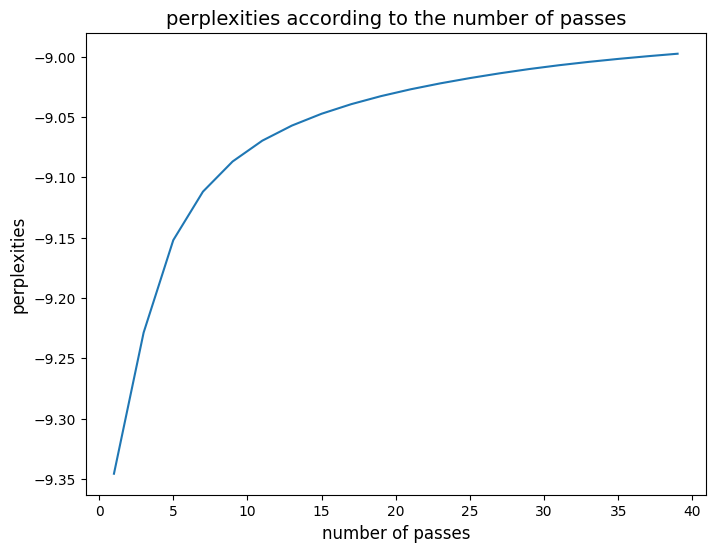

In [51]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
x=[i for i in range(1,40,2)]
ax1.plot(x,perplexities)
ax1.set_title('perplexities according to the number of passes', size=14)
ax1.set_ylabel('perplexities',fontsize=12)
ax1.set_xlabel('number of passes',fontsize=12)

In [33]:
coherences2=[]
perplexities2=[]
passes=[]

for i in range(1,15):

    tic = time.time()
    
    lda = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=dictionary,
                                            iterations=400,passes=5,
                                           alpha=0.3,eta=0.3,random_state=10)
    print(i,"time:",time.time() - tic)

    cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences2.append(coherence)
    print('Perplexity: ', lda.log_perplexity(corpus),'\n\n')
    perplexities2.append(lda.log_perplexity(corpus))

1 time: 0.928520679473877
Cpherence -1.558276334654641
Perplexity:  -9.181689098640968 


2 time: 9.977895498275757
Cpherence -2.5148509429038866
Perplexity:  -9.123349302323664 


3 time: 11.694155931472778
Cpherence -3.946021475506173
Perplexity:  -9.14614194983074 


4 time: 12.230046272277832
Cpherence -3.6445946457552827
Perplexity:  -9.152054127445668 


5 time: 12.227698802947998
Cpherence -3.188584330305463
Perplexity:  -9.05416672190651 


6 time: 12.82528567314148
Cpherence -2.9226390200811587
Perplexity:  -9.096371899019054 


7 time: 12.91523790359497
Cpherence -3.0528492612096243
Perplexity:  -9.10772706491322 


8 time: 12.884485006332397
Cpherence -3.9017554418721128
Perplexity:  -9.103888835361024 


9 time: 13.466848373413086
Cpherence -4.196452697905158
Perplexity:  -9.122084084537073 


10 time: 13.410016536712646
Cpherence -3.909293809700505
Perplexity:  -9.08807814350301 


11 time: 13.738304138183594
Cpherence -3.8172297315240242
Perplexity:  -9.069517069362481 



Text(0.5, 0, 'number of topics')

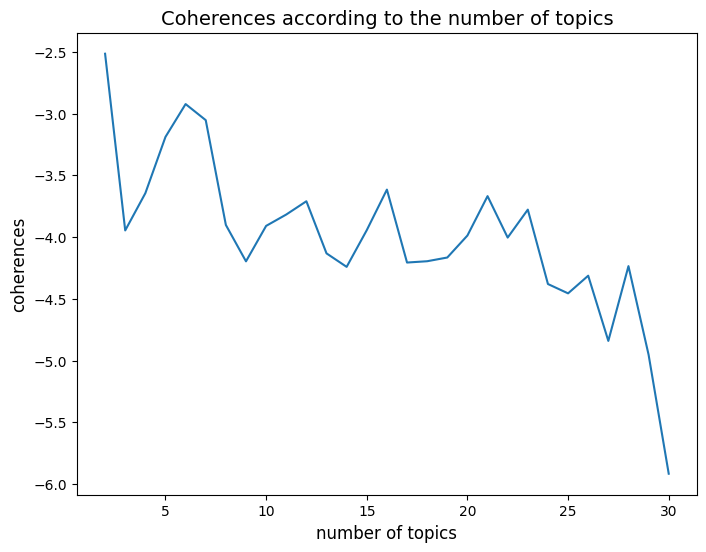

In [49]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
x=[i for i in range(2,31)]
ax1.plot(x,coherences2[1:])
ax1.set_title('Coherences according to the number of topics', size=14)
ax1.set_ylabel('coherences',fontsize=12)
ax1.set_xlabel('number of topics',fontsize=12)

Text(0.5, 0, 'number of topics')

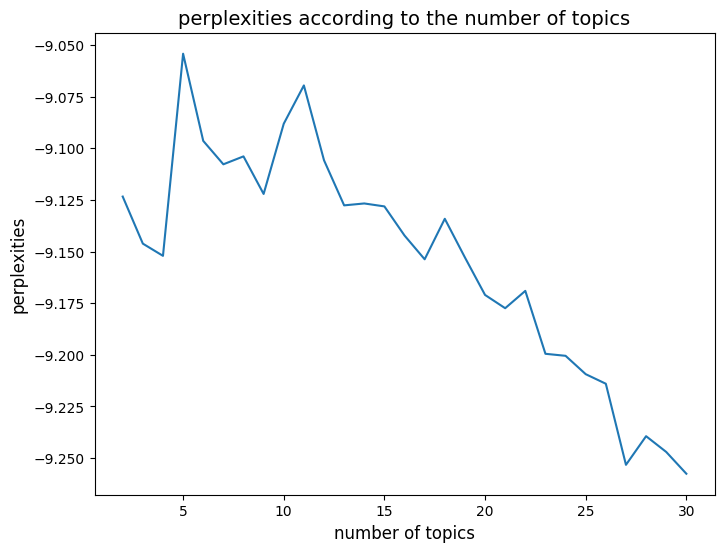

In [52]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
x=[i for i in range(2,31)]
ax1.plot(x,perplexities2[1:])
ax1.set_title('perplexities according to the number of topics', size=14)
ax1.set_ylabel('perplexities',fontsize=12)
ax1.set_xlabel('number of topics',fontsize=12)

In [42]:
for i in range(15,31):

    tic = time.time()
    
    lda = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=dictionary,
                                            iterations=400,passes=5,
                                           alpha=0.3,eta=0.3,random_state=10)
    print(i,"time:",time.time() - tic)

    cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences2.append(coherence)
    print('Perplexity: ', lda.log_perplexity(corpus),'\n\n')
    perplexities2.append(lda.log_perplexity(corpus))

15 time: 12.899286270141602
Cpherence -3.943788221039127
Perplexity:  -9.128112442774453 


16 time: 12.830421209335327
Cpherence -3.615414316332783
Perplexity:  -9.142218910802521 


17 time: 13.120465755462646
Cpherence -4.206121885417695
Perplexity:  -9.153725396227427 


18 time: 12.992806673049927
Cpherence -4.195524245210031
Perplexity:  -9.134110058764351 


19 time: 13.428320169448853
Cpherence -4.165395842498681
Perplexity:  -9.152830010672975 


20 time: 13.185111284255981
Cpherence -3.9872860787328954
Perplexity:  -9.170989835668877 


21 time: 13.78266191482544
Cpherence -3.6682322438120525
Perplexity:  -9.177418528266797 


22 time: 13.633721351623535
Cpherence -4.003912056330568
Perplexity:  -9.169023675339417 


23 time: 13.733214139938354
Cpherence -3.7775294506417385
Perplexity:  -9.199497622970185 


24 time: 13.337549686431885
Cpherence -4.380102544128086
Perplexity:  -9.200474956007128 


25 time: 13.6198251247406
Cpherence -4.455700307846016
Perplexity:  -9.2093598

In [45]:
import gensim
a=0.2
b=0.2
num_topics = 6
passes = 5
iterations = 400
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary,
                                            iterations=iterations,passes=passes,
                                           alpha=a,eta=b,random_state=10)

In [53]:
ldamodel.print_topics(num_words=7) 

[(0,
  '0.020*"조국_혁신" + 0.010*"영향" + 0.009*"전북" + 0.008*"전망" + 0.007*"시장" + 0.006*"투표" + 0.006*"증시"'),
 (1,
  '0.011*"의원" + 0.009*"제주" + 0.008*"예비_후보" + 0.007*"공천" + 0.007*"경선" + 0.004*"안산" + 0.004*"대표"'),
 (2,
  '0.019*"교육" + 0.012*"정신_교육" + 0.012*"선정" + 0.010*"내용" + 0.009*"국방부" + 0.008*"지지" + 0.007*"장병"'),
 (3,
  '0.006*"남양주" + 0.006*"시민" + 0.006*"친환경_선거" + 0.005*"주말" + 0.005*"사용" + 0.005*"공약" + 0.004*"후보_등록"'),
 (4,
  '0.010*"이재명" + 0.008*"진지" + 0.008*"대표" + 0.007*"고양시" + 0.007*"문제" + 0.007*"사람" + 0.007*"국가"'),
 (5,
  '0.016*"목사" + 0.011*"기도" + 0.009*"회장" + 0.009*"교회" + 0.008*"사람" + 0.008*"대표_회장" + 0.008*"나라"')]

0.5

In [59]:
dictionary2 = corpora.Dictionary(words_bigram)  # 각 단어에 번호를 할당해줌
    # bigram 포함하는 과정을 생략하고 싶으면, 그냥 바로 여기에 tokenized_list를 넣어주면 됨

dictionary2.filter_extremes(no_below=2, no_above=0.5)   
    # 2개의 문서 미만으로 등장하는 단어는 제외, 전체의 50% 이상으로 자주 등장하는 단어는 제외

corpus2 = [dictionary2.doc2bow(text) for text in words_bigram]
print(corpus2[0]) # 첫번째 corpus를 테스트로 출력: 몇 번째 단어가 몇 번 나왔는지 저장되어 있음

[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 4), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 3), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 7), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 3), (55, 1), (56, 1), (57, 2), (58, 2), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1)]


In [61]:
import gensim
a=0.2
b=0.2
num_topics = 6
passes = 5
iterations = 400
ldamodel = gensim.models.ldamodel.LdaModel(corpus2, num_topics = num_topics, id2word=dictionary2,
                                            iterations=iterations,passes=passes,
                                           alpha=a,eta=b,random_state=10)

In [62]:
ldamodel.print_topics(num_words=7)

[(0,
  '0.014*"후보" + 0.008*"의원" + 0.008*"국회의원" + 0.007*"지역" + 0.007*"예비_후보" + 0.005*"공천" + 0.004*"개혁_신당"'),
 (1,
  '0.015*"교육" + 0.008*"고양시" + 0.008*"정신_교육" + 0.007*"문제" + 0.007*"일산" + 0.007*"이재명" + 0.006*"내용"'),
 (2,
  '0.018*"목사" + 0.015*"후보" + 0.012*"기도" + 0.011*"한기총" + 0.010*"회장" + 0.010*"교회" + 0.009*"대표_회장"'),
 (3,
  '0.018*"후보" + 0.015*"선거" + 0.013*"조국_혁신" + 0.011*"전북" + 0.010*"출정" + 0.008*"친환경_선거" + 0.008*"지역"'),
 (4,
  '0.016*"후보" + 0.008*"대표" + 0.007*"조국_혁신" + 0.007*"사람" + 0.007*"이재명" + 0.006*"진지" + 0.006*"나라"'),
 (5,
  '0.020*"후보" + 0.009*"제주" + 0.008*"선거" + 0.007*"정치" + 0.005*"관심" + 0.005*"투표" + 0.005*"결과"')]